## Training Notebook

This notebook is a tool to train the neural network for binary classification using the LFW Dataset.

In [57]:
# Import thrid party libraries

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Import utility libraries

from utils.triplet_generator import TripletGenerator

# Import the core library from the system

from core.face_encoder import FaceEncoder

In [58]:
triplet_generator = TripletGenerator()
face_encoder = FaceEncoder()

[Encoder Network] starting....
[Inception ResNet V1] start to initialize...
[Inception ResNet V1] finish initialize...
[Encoder Network] finish initialization....
[Inception ResNet V1] start loading weights...
[Inception ResNet V1] finish loading weights...
[Encoder Network] weights load successfully


In [59]:
# Generate triplets pairs to ease the setting up the data for training

triplet_generator.lfw_dataset_source('\data\lfw')
(anchors, positives, negatives) = triplet_generator.create_triplets()

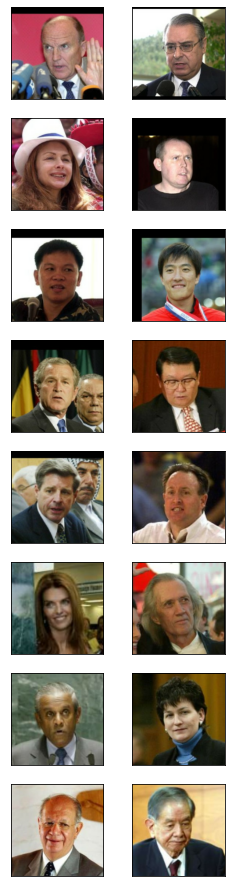

In [60]:
# Visualize Training Data Positive Pair and Negative Pair

from random import seed
from random import randint

target_shape = (160, 160)

def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

def show(ax, image):
    ax.imshow(preprocess_image(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


fig = plt.figure(figsize=(4, 16))

axs = fig.subplots(8, 2)

seed(5)

for i in range(8):
    value = randint(0, len(anchors))
    show(axs[i, 0], anchors[value])
    show(axs[i, 1], negatives[value])

plt.show()

In [61]:
print("Anchor: {}".format(np.shape(anchors)))
print("Positive: {}".format(np.shape(positives)))
print("Negative: {}".format(np.shape(negatives)))

Anchor: (4069,)
Positive: (4069,)
Negative: (4069,)


In [62]:
# Feature extraction to get face embedding vectors, in (anchor, positive) and (anchor, negative) pair

pair_embeddings = []
y = []

length = len(anchors)

for idx in range(length):
  anchor_embedding = face_encoder.get_embedding(image_path=anchors[idx])
  positive_embedding = face_encoder.get_embedding(image_path=positives[idx])
  negative_embedding = face_encoder.get_embedding(image_path=negatives[idx])

  pair_embeddings.append((anchor_embedding, positive_embedding))
  y.append(1)
  pair_embeddings.append((anchor_embedding, negative_embedding))
  y.append(0)


np.save('./data/encodings/lfw_face_embeddings.npy', pair_embeddings)

In [63]:
# Load face embedding pairs

pair_embeddings = np.load('./data/encodings/lfw_face_embeddings.npy')

In [64]:
X = []
y = []

length = len(anchors)

for _ in range(length):
  y.append(1)
  y.append(0)

for embedding in pair_embeddings:
  X.append(np.array(embedding[0] - embedding[1]).reshape(-1))

X_train = np.array(X)
y_train = np.array(y).reshape(-1)

In [65]:
def classifier_scheduler(epoch, lr):
  if (epoch % 5 == 0):
    return lr * tf.math.exp(-0.1)
  
  return lr

ClassifierLearningRateScheduler = LearningRateScheduler(classifier_scheduler, verbose=1)
ClassifierCustomEarlyStopping = EarlyStopping(monitor='loss', patience=3)

classifier = Sequential([
            Input(shape=(128,)),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

In [66]:
classifier.compile(loss='binary_crossentropy', optimizer=Adam(0.002), metrics=['accuracy'])
classifier_training_history = classifier.fit(X_train, y_train, validation_split=0.2, callbacks=[
               ClassifierLearningRateScheduler, ClassifierCustomEarlyStopping], epochs=20, verbose=1)


Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0018096749, shape=(), dtype=float32).
Epoch 1/20
204/204 [==============================] - 1s 2ms/step - loss: 0.6485 - accuracy: 0.6346 - val_loss: 0.6024 - val_accuracy: 0.6978 - lr: 0.0018

Epoch 00002: LearningRateScheduler setting learning rate to 0.0018096748972311616.
Epoch 2/20
204/204 [==============================] - 0s 1ms/step - loss: 0.5602 - accuracy: 0.7363 - val_loss: 0.5345 - val_accuracy: 0.7457 - lr: 0.0018

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018096748972311616.
Epoch 3/20
204/204 [==============================] - 0s 1ms/step - loss: 0.5037 - accuracy: 0.7684 - val_loss: 0.5022 - val_accuracy: 0.7635 - lr: 0.0018

Epoch 00004: LearningRateScheduler setting learning rate to 0.0018096748972311616.
Epoch 4/20
204/204 [==============================] - 0s 1ms/step - loss: 0.4725 - accuracy: 0.7783 - val_loss: 0.4801 - val_accuracy: 0.7678 - lr: 0.0018

Epoch 00005: Lea

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


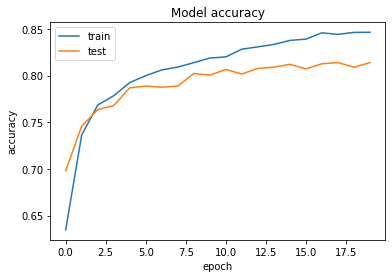

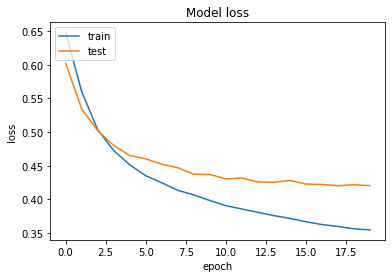

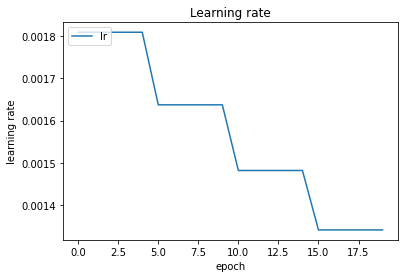

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,161
Trainable params: 4,161
Non-trainable params: 0
_________________________________________________________________


In [67]:
print(classifier_training_history.history.keys())

plt.plot(classifier_training_history.history['accuracy'])
plt.plot(classifier_training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(classifier_training_history.history['loss'])
plt.plot(classifier_training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(classifier_training_history.history['lr'])
plt.title('Learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['lr'], loc='upper left')
plt.show()

classifier.summary()

In [68]:
classifier.save("./data/models/classifier_keras_weights.h5")